# Jupyter User Manual

This notebook is meant as a sort of "on the job" user manual where you can see how pyfel1d works in practice with extensive commenting. I'm going to set up a time-dependent simulation of a bunch with a finite length where there is both a seed field and initial shot noise microbunching. The beam will have a gaussian energy spread of rms width 0.5 and a chirp $d\hat{\eta}/d\zeta=0.02$. We will keep track of the 1st, 3rd, and 5th harmonics, and quadratically taper the undulator strength starting halfway through the simulation.

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import sys
sys.path.append('/Users/riverr/Documents/pyfel1d/main/')
from particles import ParticleLoader
from fel import OneDFELSolver
import time

First we define an instance of the OneDFELSolver class.

In [21]:
solver = OneDFELSolver(Lzhat=25, # undulator length is 25 in scaled units
                       Nzhat=1500, # we take 1500 steps through the undulator 
                       Lzeta=30, # the beam window in zeta is 30 units long
                       Nzeta = 500, # we discretize the beam into 1000 slices
                       time_independent=False) # this will be a time-dependent run

In [22]:
print(f'zhat step is {solver.dzhat:.3f}')
print(f'zeta step is {solver.dzeta:.3f}')
print(f'Number of slices is {solver.Nzeta}')

zhat step is 0.017
zeta step is 0.060
Number of slices is 500


Next we'll define the beam current shape by setting the chi parameter. We'll pick a supergaussian beam at the center of the simulation window with a FWHM of 20 and a supergaussian parameter $P=3$.

In [23]:
zeta = solver.zeta_arr ## define zeta so that the later lines are a bit cleaner 

chi_zeta0 = zeta.mean()
chi_fwhm = 20
supergauss_P = 3

solver.chi = np.exp(-np.log(2)*(4*(zeta-chi_zeta0)**2/chi_fwhm**2)**supergauss_P)

Text(0, 0.5, 'Beam profile $\\chi$')

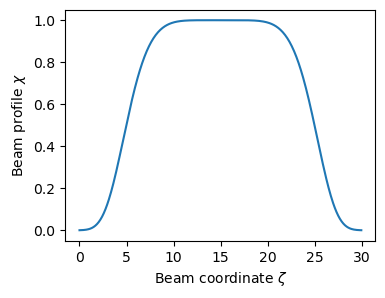

In [24]:
plt.figure(figsize=(4,3))
plt.plot(zeta, solver.chi)
plt.xlabel(r'Beam coordinate $\zeta$')
plt.ylabel(r'Beam profile $\chi$')

Next we'll define the seed field and the harmonics we want tracked. We will only provide a seed field at the fundamental frequency, which we can specify as a 1D array. That seed will be a gaussian with rms width 1, amplitude 1e-3, and center at the lower half-max point of the beam profile. Since we want harmonics tracked, we also have to provide K0, which I'll set as 3.

In [25]:
a0_zeta0 = chi_zeta0 - chi_fwhm/2
a0_amp = 1e-3
a0_rms = 1

solver.a0 = a0_amp*np.exp(-(zeta - a0_zeta0)**2/(2*a0_rms**2))

solver.harmonics = [1,3]
solver.K0 = 3

Text(0, 0.5, 'Seed field $a_0$')

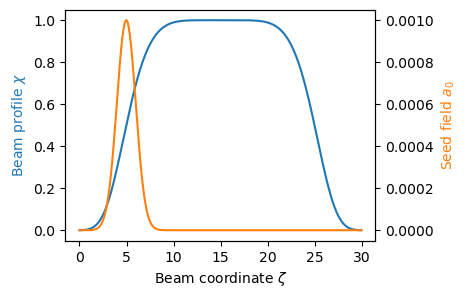

In [26]:
fig, ax = plt.subplots(figsize=(4,3))

ax.plot(zeta, solver.chi)

ax2 = ax.twinx()

ax2.plot(zeta, solver.a0, 'C1')

ax.set_xlabel(r'Beam coordinate $\zeta$')
ax.set_ylabel(r'Beam profile $\chi$', color='C0')
ax2.set_ylabel(r'Seed field $a_0$', color='C1')

Now we need to initalize the particles. I'll use the generate_beam function within the OneDFELSolver class to initialize a beam with rms shot noise bunching at the level 1e-4.

In [27]:
solver.generate_beam(bdes=1e-4, # desired rms bunching
                     chirp_arr=0.02*zeta, # desired chirp, I set it to 0.02*zeta leading to a linear chirp of 0.02 eta per 1 zeta
                     slice_espread_function=lambda Np: np.random.normal(0, 0.5, Np)) # gaussian slice energy spread with rms width 0.5

The bunching up to around the 8th harmonic is what we asked for, after which it starts to misbehave. That's okay since we're only simulating up to the 5th harmonic


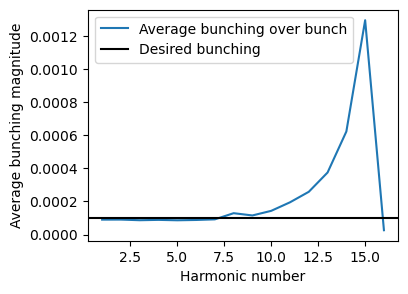

Because enforce_bunching is False, the actual bunching fluctuates from slice to slice though the mean is what we asked for


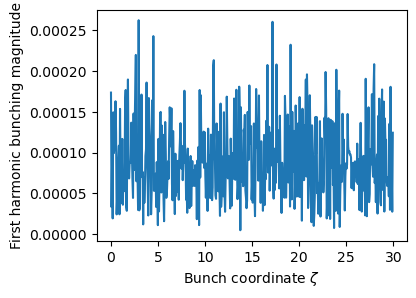

In [28]:
harms_to_plot = np.arange(1, 17)
bunchings = np.zeros((harms_to_plot.shape[0], solver.Nzeta))
for n in harms_to_plot:
    bunchings [n-1] = np.abs(np.mean(np.exp(1j*n*solver.theta0), axis=-1))

print("The bunching up to around the 8th harmonic is what we asked for, after which it starts to misbehave. That's okay since we're only simulating up to the 5th harmonic")
plt.figure(figsize=(4,3))
plt.plot(harms_to_plot, np.mean(bunchings, axis=1), label='Average bunching over bunch')
plt.axhline(1e-4, color='k', label='Desired bunching')
plt.xlabel('Harmonic number')
plt.ylabel('Average bunching magnitude')
plt.legend()
plt.show()

print("Because enforce_bunching is False, the actual bunching fluctuates from slice to slice though the mean is what we asked for")
plt.figure(figsize=(4,3))
plt.plot(zeta, bunchings[0])
plt.xlabel(r'Bunch coordinate $\zeta$')
plt.ylabel('First harmonic bunching magnitude');

Text(0.5, 1.0, 'Beam phase space')

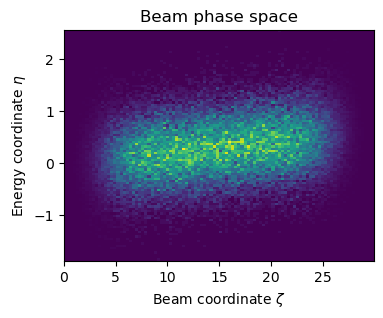

In [29]:
plt.figure(figsize=(4,3))
plt.hist2d(np.array([np.ones(solver.theta0.shape[1])*solver.zeta_arr[i] for i in range(solver.Nzeta)]).flatten(), solver.eta0.flatten(), [100,100], weights=np.array([np.ones(solver.theta0.shape[1])*solver.chi[i] for i in range(solver.Nzeta)]).flatten());
plt.xlabel(r'Beam coordinate $\zeta$')
plt.ylabel(r'Energy coordinate $\eta$')
plt.title('Beam phase space')

The last thing we need to specify is the taper. We will use a quadratic taper starting from halfway through the undulator. 

In [30]:
z = solver.zhat_arr ## again, defining z for cleaner code below

taper_z0 = z.mean()
taper_coeff = -0.01
solver.taper = np.heaviside(z - taper_z0, 0)*taper_coeff*(z - taper_z0)**2

Text(0, 0.5, 'Normalized taper $\\Delta$')

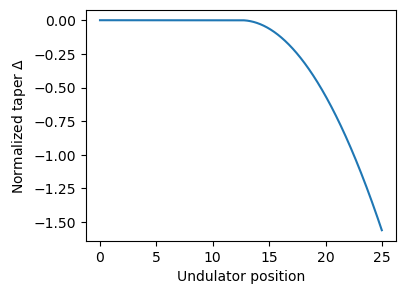

In [31]:
plt.figure(figsize=(4,3))
plt.plot(z, solver.taper)
plt.xlabel('Undulator position')
plt.ylabel(r'Normalized taper $\Delta$')

Now that we have defined everything about the simulation, we can run it.

In [32]:
%%time
solver.run_simulation(steps_between_store=10,
                      verbose=True,
                      store_particles=True)

1D vector input for a0 is assumed to be for the first harmonic
Beginning simulation including harmonics: [1 3]
0% done
10% done
20% done
30% done
40% done
50% done
60% done
70% done
80% done
90% done
Done
CPU times: user 4min 2s, sys: 11.4 s, total: 4min 13s
Wall time: 39.1 s


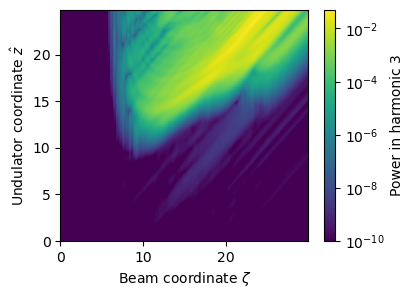

In [33]:
plt.figure(figsize=(4,3))
i = 1 ## harmonic to plot
plt.imshow(1e-12+np.abs(solver.a_store[:,i])**2, aspect='auto', origin='lower', norm=LogNorm(vmin=1e-10), extent=[0, solver.zeta_arr.max(), 0, solver.zhat_store.max()])
plt.xlabel(r'Beam coordinate $\zeta$')
plt.ylabel(r'Undulator coordinate $\hat{z}$')
plt.colorbar(label=f'Power in harmonic {solver.harmonics[i]}')

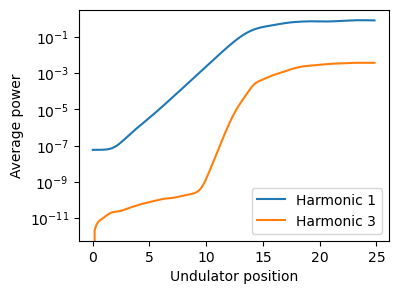

In [34]:
plt.figure(figsize=(4,3))
for i,h in enumerate(solver.harmonics):
    plt.plot(solver.zhat_store, np.mean(np.abs(solver.a_store[:,i])**2, axis=-1), label=f'Harmonic {h}')
plt.xlabel('Undulator position')
plt.ylabel('Average power')
plt.legend()
plt.yscale('log')
    

Text(0.5, 1.0, 'Phase space at z=20')

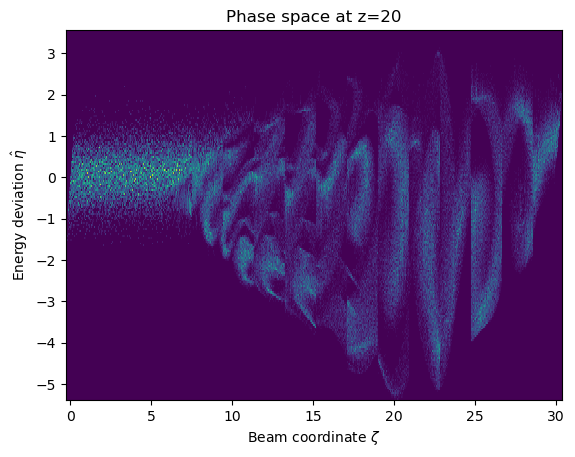

In [39]:
theta_expanded = solver.zeta_arr[None,:,None] + solver.theta_store*solver.dzeta/(2*np.pi)

z_plot = 20
z_ind = np.argmin(abs(solver.zhat_store - z_plot))
plt.hist2d(theta_expanded[z_ind].flatten(), solver.eta_store[z_ind].flatten(), [2000, 200]);
plt.xlabel(r'Beam coordinate $\zeta$')
plt.ylabel(r'Energy deviation $\hat{\eta}$')
plt.title(f'Phase space at z={z_plot}')